## Sentiment Analysis in Python

## In this note book we will be doing some sentiment analysis in python using two different techniques:
### 1. VADER (Bag of words approach)
### 2. Roberta Pretrained Model from HuggingFace
### 3. Huggingface Pipeline

## Read in the Data and NLTK basics

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [6]:
df = pd.read_csv('Reviews.csv')
print(df.shape)
# Since the shape of data is too high, therefore for now, limiting it to only the top 2000 rows
df = df.head(2000)
print('only taking top 2k rows as dataset size is around 550k')
print(df.shape)

(568454, 10)
only taking top 2k rows as dataset size is around 550k
(2000, 10)


##### Note: Here, Score column refers to the review score and the Text column refers to the review in the data. Other columns being product information, user information, profile etc.

### Preliminary EDA 

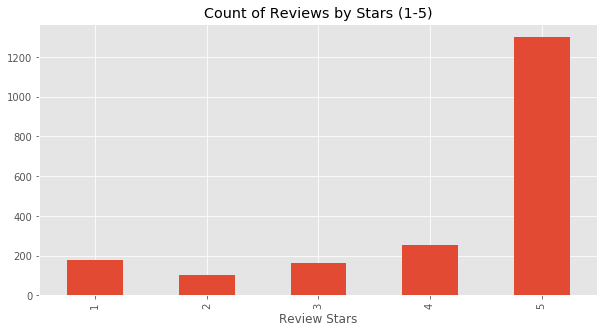

In [8]:
ax = df['Score'].value_counts().sort_index().plot(kind = 'bar', title = 'Count of Reviews by Stars (1-5)'
                                             , figsize = (10,5))

ax.set_xlabel('Review Stars')
plt.show()

#### As we took the top 2000 rows and based off of this plot, we can see that the data is biased towards 5* review/positive review

### Basic NLTK

In [9]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [12]:
# nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/priyanuj/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [16]:
# nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/priyanuj/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [19]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [23]:
# nltk.download('maxent_ne_chunker')
# nltk.download('words')

[nltk_data] Downloading package words to /Users/priyanuj/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [25]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


### Step 1: VADER Sentiment Scoring

In [26]:
# We will use NLTK's SentimentIntensityAnalyzer to get the negative/neutral/positive scores of the text

# This uses a "bag of words" approach
# 1. Stop words are removed
# 2. each word is scored and combined to a total score

In [30]:
# nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/priyanuj/nltk_data...


True

In [31]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [32]:
#How sia would work
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [33]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [35]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [37]:
# df.shape[0] or len(df) would work

2000

In [39]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total = df.shape[0]):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

In [48]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index': 'Id'})
vaders.head()

,Id,neg,neu,pos,compound
0,1,0.000,0.695,0.305,0.9441
1,2,0.138,0.862,0.000,-0.5664
2,3,0.091,0.754,0.155,0.8265
3,4,0.000,1.000,0.000,0.0000
4,5,0.000,0.552,0.448,0.9468


In [49]:
# Now we have sentiment score and metadata
vaders = vaders.merge(df, how = 'left')
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Making some assumptions

In [52]:
# If the id has given a 5 star score, then it is mostly going to be a more positive review than a row with rating 1

Text(0.5, 0, 'Compound score by amazon star review')

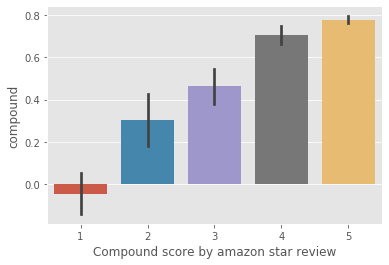

In [51]:
ax = sns.barplot(data = vaders, x = 'Score', y = 'compound')
ax.set_xlabel('Compound score by amazon star review')

#### Exactly how we would expect!

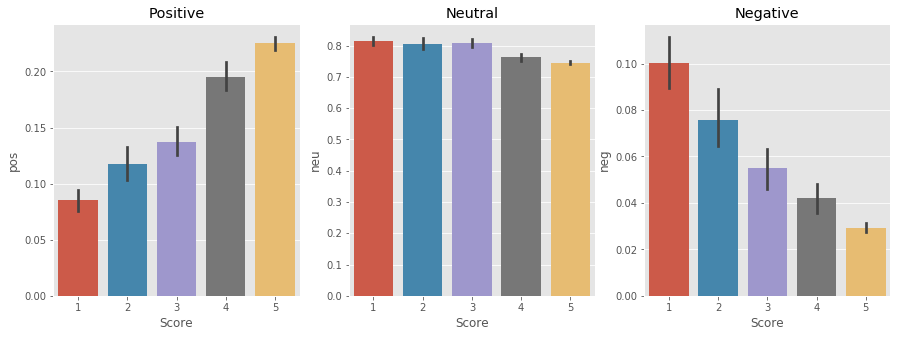

In [58]:
fig, axs = plt.subplots(1,3, figsize = (15,5))
sns.barplot(data = vaders, x = 'Score', y = 'pos', ax=axs[0])
sns.barplot(data = vaders, x = 'Score', y = 'neu', ax=axs[1])
sns.barplot(data = vaders, x = 'Score', y = 'neg', ax=axs[2])

axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

#### VADER can only account for words but cannot relate to the context related to other words, for example it will miss out on sarcasm

### Roberta Pretrained Model

#### Use a model trained on a large corpus of data
#### Transformer model accounts for the words but also the context related to other words

In [74]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

ImportError: cannot import name 'ObjectWrapper' from 'tqdm.utils' (/opt/anaconda3/lib/python3.7/site-packages/tqdm/utils.py)